In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split, prepare_vectors, quaternion_to_6d_batch, mean_abs_err
from utils import save_parameters_to_csv

torch.manual_seed(42)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Two body: prolate

Mar 23
+ Angular error on symmetric axis (i.e. z-axis) is consistently far lower than other 2.
    + Actually, we don't really care about rotation around symmetric axis at all.
+ Angular velocity relative % error is quite bad, but this might still work
+ 

In [2]:
times = ['20:52', '21:59', '22:19', '22:48', '23:36', '23:55',
        '23:36_close2', '23:52_close', '03:53_497',
        '03:47_33', '03:45_765']
new_times = ['04:56_348', '04:55_309', '04:55_430'] #R.random()

xs,ys = [],[]
for t in times+new_times:
    x = np.load(f"../data/X_prolateSpheroid_{t}.npy")
    y = np.load(f"../data/Y_prolateSpheroid_{t}.npy")

    xs.append(x)
    ys.append(y)

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)

XY = np.hstack([X, Y])          # shape: (total_rows, 16)

column_names = [
    # X columns (10)
    "center_x", "center_y", "center_z", "dist", "min_dist",
    "quat_x", "quat_y", "quat_z", "quat_w",
    "force_x", "force_y", "force_z",
    "torque_x", "torque_y", "torque_z",
    # Y columns (6)
    "vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"
]

df = pd.DataFrame(XY, columns=column_names)
# df['a'] = 1.0
# df['b'] = 1.0
# df['c'] = 3.0

In [3]:
#df = pd.read_csv(f"../data/sphere_2body_28k.csv").drop(columns=['Unnamed: 0'])

#df = df[df["min_dist"]<8]
df.shape, df.columns

((44505, 21),
 Index(['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'quat_x',
        'quat_y', 'quat_z', 'quat_w', 'force_x', 'force_y', 'force_z',
        'torque_x', 'torque_y', 'torque_z', 'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'],
       dtype='object'))

In [4]:
# We don't care about rotation about symmetry axis
# df['angvel_z'] = 0.0

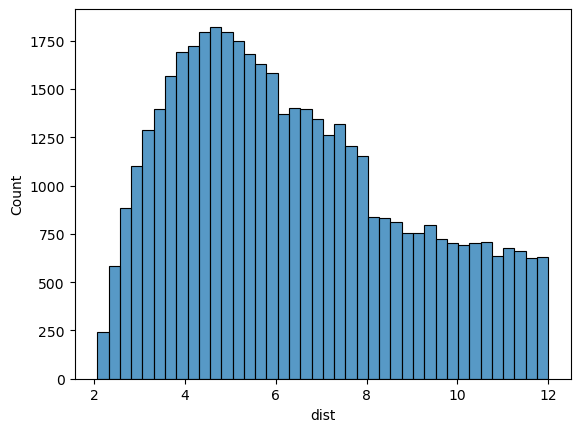

In [5]:
sns.histplot(df["dist"], bins=40);

In [6]:
# CVPR: On the continuity of rotation representations in neural networks'19
quaternions = df[['quat_x', 'quat_y', 'quat_z', 'quat_w']].values

# Convert to 6D using the function defined
quaternion_6d = quaternion_to_6d_batch(quaternions)

# New 6D column names
quaternion_6d_columns = ['quat_6d_1', 'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6']

# Replace the original quaternion columns in df with the new 6D representations
df = df.drop(['quat_x', 'quat_y', 'quat_z', 'quat_w'], axis=1)
for i, col in enumerate(quaternion_6d_columns):
    df[col] = quaternion_6d[:, i]

df.shape, df.columns

((44505, 23),
 Index(['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'force_x',
        'force_y', 'force_z', 'torque_x', 'torque_y', 'torque_z', 'vel_x',
        'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z', 'quat_6d_1',
        'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6'],
       dtype='object'))

In [7]:
def prepare_vectors(df):
    force_cols = ['force_x', 'force_y', 'force_z', 
                  "torque_x", "torque_y", "torque_z",]
    output_cols = ['vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y' , 'angvel_z']
    feature_cols = [col for col in df.columns if col not in (force_cols + output_cols)]
    #print(feature_cols)
    
    dist_vec = df[feature_cols].values
    force_vec = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec


def add_fourier_features(
    df: pd.DataFrame,
    columns_to_transform: list,
    max_freq: int = 4,
    include_original: bool = True
) -> pd.DataFrame:
    
    # Dictionary to hold the new Fourier feature columns
    fourier_features = {}
    
    for col in columns_to_transform:
        for f in range(1, max_freq + 1):
            # Sine transform
            fourier_features[f"{col}_sin_{f}"] = np.sin(2.0 * np.pi * f * df[col])
            # Cosine transform
            fourier_features[f"{col}_cos_{f}"] = np.cos(2.0 * np.pi * f * df[col])
    
    # Option 1: Append Fourier features to the original DataFrame
    if include_original:
        df_out = pd.concat([df, pd.DataFrame(fourier_features)], axis=1)
    else:
        # Option 2: Return only the newly generated Fourier columns
        df_out = pd.DataFrame(fourier_features)
    
    return df_out


# columns_for_fourier = ['dist', 'min_dist']

# # Generate a new DataFrame with the extra Fourier features
# df = add_fourier_features(df, columns_for_fourier, max_freq=4, include_original=True)
# df.columns, df.shape

In [8]:
def input_mapping(x, B):
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

mapping_size = 32
d = 3
scale = 1.0
B_gauss = np.random.randn(mapping_size, d)
B = B_gauss * scale
print(B.shape)

x = df[['center_x', 'center_y', 'center_z']].values
feats = input_mapping(x, B)

cols = [f"four_{t}" for t in range(feats.shape[1])]
df_new = pd.DataFrame({c:feats[:,i].copy() for i,c in enumerate(cols)})
df_new.index = df.index  # force them to match

assert df_new.isna().any().any()==False

#df = pd.concat([df, df_new], axis=1) #.drop(columns=['center_x', 'center_y', 'center_z'])

feats.shape, x.shape, B.shape, df.shape

(32, 3)


((44505, 64), (44505, 3), (32, 3), (44505, 23))

In [9]:
df.columns

Index(['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'force_x',
       'force_y', 'force_z', 'torque_x', 'torque_y', 'torque_z', 'vel_x',
       'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z', 'quat_6d_1',
       'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6'],
      dtype='object')

In [10]:
# def multiscale(x, scales):
#     return np.hstack([x.reshape(-1, 1)/pow(3., i) for i in scales])


# def encode_scalar_column(x, scales=[-1, 0, 1, 2, 3, 4, 5, 6]):
#     return np.hstack([np.sin(multiscale(x, scales)), np.cos(multiscale(x, scales))])

# feat_dist = encode_scalar_column(df['dist'].values)

# cols = [f"four_{t}" for t in range(feat_dist.shape[1])]
# df_new = pd.DataFrame({c:feat_dist[:,i].copy() for i,c in enumerate(cols)})
# df_new.index = df.index  # force them to match

# assert df_new.isna().any().any()==False

# df = pd.concat([df, df_new], axis=1) #.drop(columns=['center_x', 'center_y', 'center_z'])
# feat_dist.shape, df_new.shape, df.shape

In [11]:
assert df.isna().any().any()==False

In [12]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape, train_velocity_tensor.shape

(torch.Size([35604, 11]),
 torch.Size([35604, 6]),
 torch.Size([8901, 11]),
 torch.Size([35604, 6]))

In [13]:
def L1(d):
    """ Computes the outer product of each 3D vector in the batch with itself. """
    # d: [batch_size, 3]
    return torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]

def L2(d):
    """ Returns the matrix (I - outer(d, d)) for each vector in the batch. """
    # Identity tensor expanded to batch size
    batch_size = d.shape[0]
    I = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).to(device)  # [batch_size, 3, 3]
    ddT = torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]
    return I - ddT

# Predefine the Levi-Civita tensor
levi_civita = torch.zeros(3, 3, 3, dtype=torch.float)
levi_civita[0, 1, 2] = 1
levi_civita[1, 2, 0] = 1
levi_civita[2, 0, 1] = 1
levi_civita[0, 2, 1] = -1
levi_civita[2, 1, 0] = -1
levi_civita[1, 0, 2] = -1

levi_civita = levi_civita.to(device)

def L3(d):
    """ Computes the cross product matrix for each 3D vector in the batch. """
    # Using einsum for batched matrix-vector multiplication:
    return torch.einsum('ijk,bk->bij', levi_civita, d)  # [batch_size, 3, 3]

def spsd_loss_func(sym_matrix, epsilon=1e-6):
    """SPSD loss representing SPSD violation
    """
    eigenvalues = torch.linalg.eigvalsh(sym_matrix)  # (batch_size, 6)
    negative_violations = torch.relu(-eigenvalues + epsilon)  # (batch_size, 6)
    loss = torch.mean(negative_violations)
    
    return loss

In [14]:
viscosity = 1.0
eigens = []

H1, H2 = 64, 128
class ScNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ScNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H1),
            nn.Tanh(),
            nn.Linear(H1, 5),
            #nn.Tanh()
        )
        
    def forward(self, r, print_scalars=False):
        x = self.layers(r)
        return x

    def predict_mobility(self, X, print_scalars=False):
        d_vec, r = X[:,:3], X[:,3]
        sc = self.forward(X, print_scalars)

        d_vec = -d_vec/ r.unsqueeze(-1) # negative,cz dvec=target-src
        TT = sc[:, 0].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 1].unsqueeze(1).unsqueeze(2) * L2(d_vec) # TODO: d_vec or r?
        RT = sc[:, 2].unsqueeze(1).unsqueeze(2) * L3(d_vec)
        RR = sc[:, 3].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 4].unsqueeze(1).unsqueeze(2) * L2(d_vec)
    
        K = torch.zeros((len(X), 6, 6), dtype=torch.float32, device=X.device)

        # After experiments, the kernel is NOT symmetric. 
        # Top-right and bottem left should NOT be transpose of each other
        K[:, :3, :3] = TT  # Top-left block
        K[:, 3:, :3] = RT  # Bottom-left block
        K[:, :3, 3:] = RT  # Top-right block (transpose of B)
        K[:, 3:, 3:] = RR  # Bottom-right block

        nonSPD = 0
        nonSym = 0
        global eigens
        if not self.training:
            print("Activating SPSD check..")
            for i in range(len(K)):
                k66 = K[i].detach().cpu()
                eigs = np.linalg.eigvals(k66)
                if not np.all(eigs>=- 1e-4):
                    eigens.append((eigs.min(), eigs.max()))
                    nonSPD += 1
                if not np.allclose(k66, k66.T, atol=1e-4):
                    nonSym += 1
                    
            print(f"{nonSPD=}, {nonSym=}, {len(K)}")
        return K

    def predict_velocity(self, X, force, return_M=False):
        M = self.predict_mobility(X)/viscosity
        velocity = torch.bmm(M, force.unsqueeze(-1)).squeeze(-1)
        if return_M:
            return velocity, M
        return velocity

class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        """        
            loss = ||y_pred - y||^2 / (||y||^2 + eps)
        """
        super(RelativeMSELoss, self).__init__()
        self.eps = eps
        
    def forward(self, predictions, targets):
        # Compute the squared error between predictions and targets.
        squared_error = (predictions - targets) ** 2
        
        # Sum the squared errors over all elements.
        mse = torch.sum(squared_error)
        
        # Compute the squared L2 norm of the targets (i.e., sum(target**2)).
        norm_squared = torch.sum(targets ** 2)
        
        # Compute the relative MSE by dividing the error by the norm (with eps for safety).
        relative_mse = mse / (norm_squared + self.eps)
        return relative_mse


## Modelling

In [15]:
input_dim = train_dist_tensor.shape[1]
batch_size = 256
epochs = 300
model = ScNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


#criterion = nn.L1Loss()
criterion = nn.MSELoss()
#criterion = RelativeMSELoss()
n_iter = train_velocity_tensor.shape[0]//batch_size
n_iter, n_iter*batch_size, len(train_dist_tensor)

(139, 35584, 35604)

In [16]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, train_velocity_tensor = shuffle_tensors(
        train_dist_tensor, train_force_tensor, train_velocity_tensor
    )
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force = train_force_tensor[indices] 
        Y = train_velocity_tensor[indices]  
    
        batch_output, M = model.predict_velocity(X, force, return_M=True)

        # Compute loss
        data_loss = criterion(batch_output, Y)
        spsd_loss = 0.1 * spsd_loss_func(M)
        loss = data_loss + spsd_loss
        
        loss.backward()
        avg += loss.item()
        avg_data += data_loss.item()
        avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)
        data_losses.append(avg_data/n_iter)
        spsd_losses.append(avg_spsd/n_iter)

torch.save(model.state_dict(), "prolate_2body.wt")

Epoch 0, Loss: 0.02601657616579235
Epoch 5, Loss: 6.794646440853579e-05
Epoch 10, Loss: 6.895540820760485e-05
Epoch 15, Loss: 7.248242641024445e-05
Epoch 20, Loss: 7.745116114073681e-05
Epoch 25, Loss: 7.213140825180692e-05
Epoch 30, Loss: 7.57983752068638e-05
Epoch 35, Loss: 8.023284950834639e-05
Epoch 40, Loss: 7.749321491946634e-05
Epoch 45, Loss: 8.126487510518352e-05
Epoch 50, Loss: 4.858761672399563e-05
Epoch 55, Loss: 4.8286960728880244e-05
Epoch 60, Loss: 5.285250708831829e-05
Epoch 65, Loss: 5.275975197671725e-05
Epoch 70, Loss: 5.402024067970154e-05
Epoch 75, Loss: 5.2279624777047045e-05
Epoch 80, Loss: 5.705203886019073e-05
Epoch 85, Loss: 5.3666735243005345e-05
Epoch 90, Loss: 5.182692511095129e-05
Epoch 95, Loss: 5.2395546145104004e-05
Epoch 100, Loss: 4.4495868920591465e-05
Epoch 105, Loss: 4.517589884193735e-05
Epoch 110, Loss: 4.6211168861557666e-05
Epoch 115, Loss: 4.5761006489386046e-05
Epoch 120, Loss: 4.558793585052339e-05
Epoch 125, Loss: 4.6092700829818216e-05
Epo

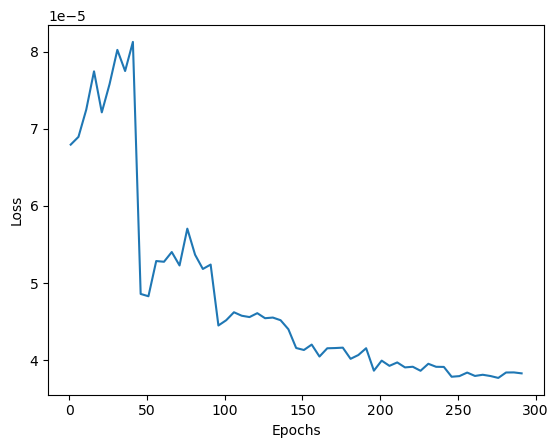

In [17]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

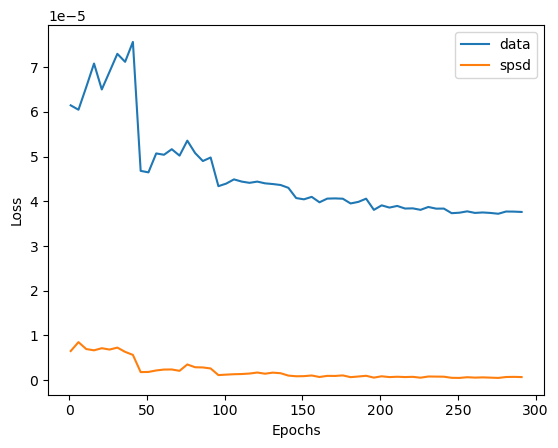

In [18]:
SKIP = 1
los = data_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='data');

los = spsd_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='spsd');

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

In [19]:
data_losses[:5], data_losses[-5:], spsd_losses[:5], spsd_losses[-5:]

([0.025862371350517964,
  6.144154633030215e-05,
  6.045912339673679e-05,
  6.553057894523578e-05,
  7.078417681225428e-05],
 [3.738296211411567e-05,
  3.7201323721092194e-05,
  3.7700782276450474e-05,
  3.767941658395148e-05,
  3.760399282955993e-05],
 [0.00015420499102278653,
  6.504918228301849e-06,
  8.496285036499721e-06,
  6.951847486026245e-06,
  6.666984140632792e-06],
 [5.598984888703311e-07,
  4.965335554772877e-07,
  6.998273843018472e-07,
  7.329116940972057e-07,
  6.850923657631886e-07])

## Evaluation

In [20]:
model = ScNetwork(input_dim).to(device)
model.load_state_dict(torch.load("prolate_2body.wt", weights_only=True))
model.eval()

eigens = []
with torch.no_grad():
    val_output, M = model.predict_velocity(val_dist_tensor, val_force_tensor, return_M=True)
    #val_output /= 5

val_output.shape, val_velocity_tensor.shape

Activating SPSD check..
nonSPD=20, nonSym=8901, 8901


(torch.Size([8901, 6]), torch.Size([8901, 6]))

In [21]:
# Save model params
directory = "/home/shihab/programs/QPGD/data/prolate2body"
save_parameters_to_csv(model, directory)

Parameters saved to /home/shihab/programs/QPGD/data/prolate2body directory.


20


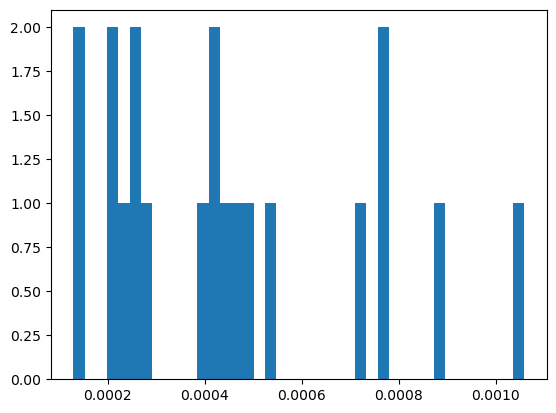

In [22]:
print(len(eigens))
if len(eigens):
    eigens = np.abs(np.array(eigens))
    plt.hist(eigens[:,0], bins=40);

In [23]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 22
val_output[jj], val_velocity_tensor[jj], 

(tensor([-0.232766,  0.000681, -0.035159, -0.001301, -0.011758, -0.022401],
        device='cuda:0'),
 tensor([-0.225947, -0.007358, -0.036221, -0.004535, -0.003404, -0.023576],
        device='cuda:0'))

In [24]:
criterion = nn.L1Loss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = err.mean(axis=0)

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([0.004572, 0.004609, 0.004206, 0.005096, 0.004911, 0.002543],
       device='cuda:0')
Actual Magnitude:
  tensor([0.092405, 0.092044, 0.089246, 0.010398, 0.010351, 0.011258],
       device='cuda:0')
RMSE: tensor(0.004323, device='cuda:0')


In [25]:
valid_mask = torch.abs(val_velocity_tensor) > 1e-4

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)


torch.nanmean(relative_error, dim=0)*100

tensor([ 14.728973,  16.998186,  14.852044, 129.716339, 136.006714,  51.277393],
       device='cuda:0')

In [26]:
a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([ 3.972242,  4.073051,  3.656710, 44.050262, 43.096901, 17.021963],
       device='cuda:0')

In [27]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([ 4.947988,  5.007482,  4.712409, 49.003716, 47.444332, 22.584194],
       device='cuda:0')

In [28]:
idx = val_dist_tensor[:,3]<4.0
mean_abs_err(val_output[idx], val_velocity_tensor[idx], ignore_thres=1e-4)

tensor([ 22.412109,  30.988649,  28.291311, 147.949509, 166.409698,  68.264565],
       device='cuda:0')

In [29]:
idx = val_dist_tensor[:,3]<2.6
mean_abs_err(val_output[idx], val_velocity_tensor[idx], ignore_thres=1e-4)

tensor([ 28.114880,  23.127773,  14.316076,  79.741379, 104.585587, 111.205055],
       device='cuda:0')

In [30]:
from scipy import stats
stats.trim_mean(relative_error.cpu().numpy(), .05, axis=0)*100

array([ 6.350386 ,  6.4583697,  5.8375235, 76.38967  , 77.55046  ,
       28.94015  ], dtype=float32)

In [31]:
mselin = (val_output[:, :3] - val_velocity_tensor[:, :3])**2
mselin = mselin.mean(axis=1)**.5
denom = (val_velocity_tensor[:, :3]**2).mean(axis=1)**.5
mselin.shape

torch.Size([8901])

In [32]:
ii = 3
val_output[ii], val_velocity_tensor[ii], mselin[ii], denom[ii]

(tensor([-0.048426,  0.079005, -0.026618, -0.003441, -0.005405, -0.008307],
        device='cuda:0'),
 tensor([-0.049583,  0.074872, -0.026657, -0.003246, -0.006569, -0.007884],
        device='cuda:0'),
 tensor(0.002478, device='cuda:0'),
 tensor(0.054083, device='cuda:0'))

In [33]:
mselin.mean(), denom.mean(), mselin.mean()/ denom.mean()

(tensor(0.005157, device='cuda:0'),
 tensor(0.105285, device='cuda:0'),
 tensor(0.048981, device='cuda:0'))

In [34]:
mseang = (val_output[:, 3:] - val_velocity_tensor[:, 3:])**2
mseang = mseang.mean(axis=1)**.5
denom = (val_velocity_tensor[:, 3:]**2).mean(axis=1)**.5

mseang.mean(), denom.mean(), mseang.mean()/ denom.mean()

(tensor(0.005043, device='cuda:0'),
 tensor(0.012406, device='cuda:0'),
 tensor(0.406500, device='cuda:0'))

## Nearfield

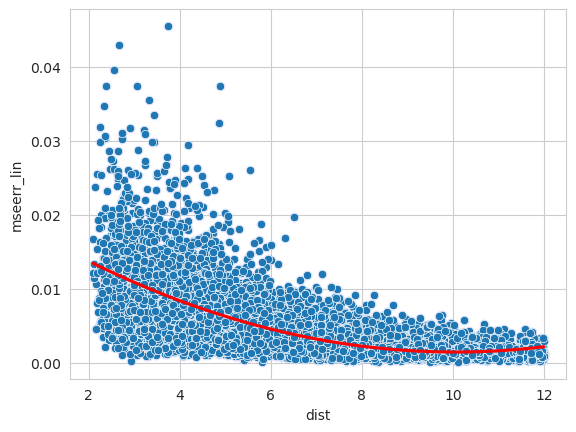

In [35]:
tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,3].cpu().numpy(),
    'mseerr_lin': mselin.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist', y='mseerr_lin', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist', y='mseerr_lin', data=tdf)
#plt.ylim(0, 100.0);


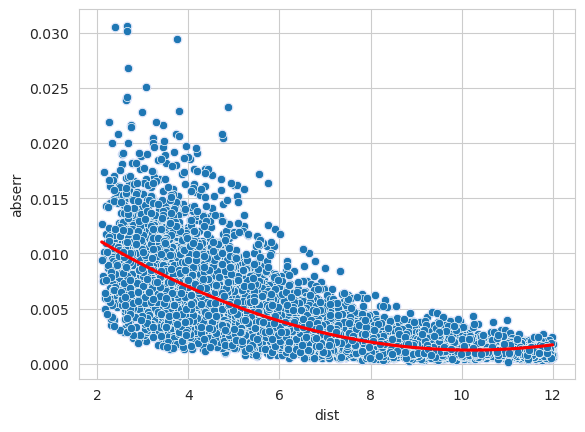

In [36]:
abserr = (torch.abs(val_output-val_velocity_tensor)).mean(axis=1)

tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,3].cpu().numpy(),
    'abserr': abserr.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist', y='abserr', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist', y='abserr', data=tdf)
#plt.ylim(0, 100.0);


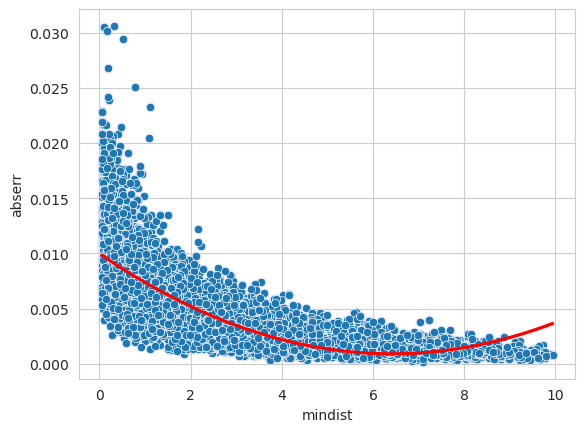

In [37]:
abserr = (torch.abs(val_output-val_velocity_tensor)).mean(axis=1)

tdf = pd.DataFrame({
    'mindist': val_dist_tensor[:,4].cpu().numpy(),
    'abserr': abserr.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='mindist', y='abserr', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='mindist', y='abserr', data=tdf)
#plt.ylim(0, 100.0);


Below 25%: 0.40759465228625996


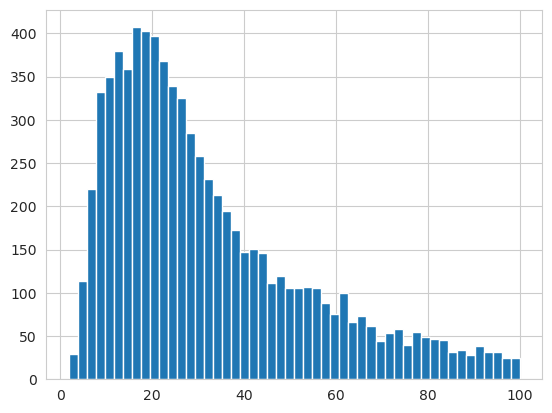

In [38]:
err = (torch.abs((val_output-val_velocity_tensor)/val_velocity_tensor)).mean(axis=1)
ddd = err.detach().cpu().numpy()*100

print("Below 25%:", (ddd<25).sum()/err.shape[0])

ddd = ddd[ddd<100]

plt.hist(ddd, bins=50);

Below 10%: 0.7245253342321087
Below 25%: 0.8781035838669813


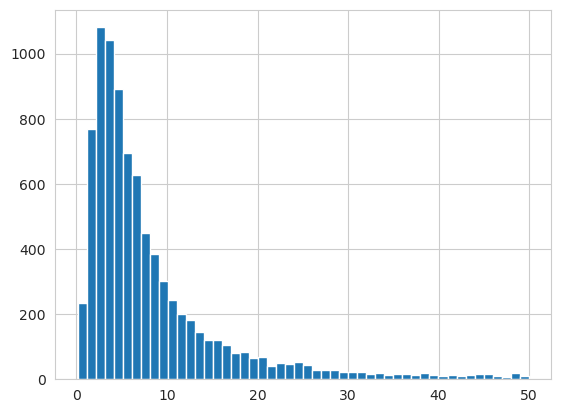

In [39]:
err = (torch.abs((val_output[:,:3]-val_velocity_tensor[:,:3])/val_velocity_tensor[:,:3])).mean(axis=1)
ddd = err.detach().cpu().numpy()*100

print("Below 10%:", (ddd<10).sum()/err.shape[0])
print("Below 25%:", (ddd<20).sum()/err.shape[0])

ddd = ddd[ddd<50]

plt.hist(ddd, bins=50);

In [40]:
err.min()

tensor(0.001570, device='cuda:0')

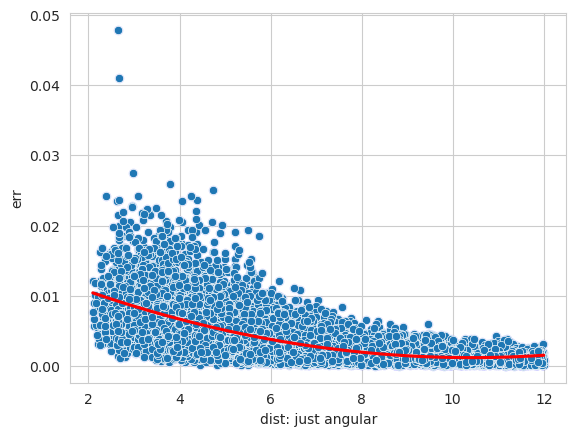

In [41]:
err = torch.abs(val_output[:,3:]-val_velocity_tensor[:,3:]).mean(axis=1)

tdf = pd.DataFrame({
    'dist: just angular': val_dist_tensor[:,3].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist: just angular', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist: just angular', y='err', data=tdf)

In [42]:
len(tdf)

8901